## Discretisation

Discretisation is the process of transforming continuous variables into discrete variables by creating a set of contiguous intervals that spans the range of the variable's values.

### Discretisation helps handle outliers and highly skewed variables

Discretisation helps handle outliers by placing these values into the lower or higher intervals together with the remaining inlier values of the distribution. Thus, these outlier observations no longer differ from the rest of the values at the tails of the distribution, as they are now all together in the same interval / bucket. In addition, by creating appropriate bins or intervals, discretisation can help spread the values of a skewed variable across a set of bins with equal number of observations.


### Discretisation approaches

There are several approaches to transform continuous variables into discrete ones. This process is also known as **binning**, with each bin being each  interval. Discretisation methods fall into 2 categories: **supervised and unsupervised**. Unsupervised methods do not use any information, other than the variable distribution, to create the contiguous bins in which the values will be placed. Supervised methods typically use target information in order to create the bins or intervals.

####  Unsupervised discretisation methods

- Equal width binning
- Equal frequency binning


#### Supervised discretisation methods

- Discretisation using decision trees


In this lecture, I will describe **equal frequency discretisation**, and in the following sections I will expand on the other methods to make variables discrete.

## Equal frequency discretisation

Equal frequency binning divides the scope of possible values of the variable into N bins, where each bin carries the same amount of observations. This is particularly useful for skewed variables as it spreads the observations over the different bins equally. Typically, we find the interval boundaries by determining the quantiles.

Equal frequency discretisation using quantiles consists of dividing the continuous variable into N quantiles, N to be defined by the user. There is no rule of thumb to define N. However, if we think of the discrete variable as a categorical variable, where each bin is a category, we would like to keep N (the number of categories) low (typically no more than 10).

Equal frequency binning is straightforward to implement and by spreading the values of the observations more evenly it may help boost the algorithm's performance. On the other hand, this arbitrary binning may also disrupt the relationship with the target on occasions. Therefore, whenever possible, it will bring value to examine whether this type of binning is the right strategy, and it will depend on the variable and the algorithm that we want to use to make the predictions.

I will demonstrate how to perform equal frequency binning using the Titanic dataset.

## Titanic dataset

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
# load the numerical variables of the Titanic Dataset

data = pd.read_csv('titanic.csv', usecols = ['Age', 'Fare', 'Survived'])
data.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [3]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data[['Age', 'Fare', 'Survived']],
                                                    data.Survived, test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((623, 3), (268, 3))

The variable Age contains missing data, that I will fill by extracting a random sample of the variable.

In [4]:
def impute_na(data, variable):
    # function to fill NA with a random sample
    
    df = data.copy()
    
    # random sampling
    df[variable+'_random'] = df[variable]
    
    # extract the random sample to fill the na
    random_sample = X_train[variable].dropna().sample(df[variable].isnull().sum(), random_state=0)
    
    # pandas needs to have the same index in order to merge datasets
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_random'] = random_sample
    
    return df[variable+'_random']

In [5]:
# replace NA in both train and test sets

X_train['Age'] = impute_na(data, 'Age')
X_test['Age'] = impute_na(data, 'Age')

### Age
#### Original distribution

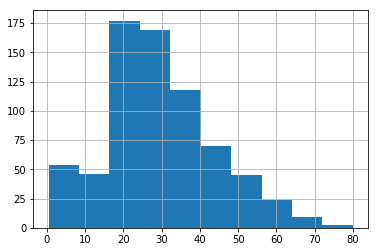

In [6]:
# let's remind ourselves of the original distribution

data.Age.hist()

**How does survival correlate with Age?**

We can determine the relation between survival and Age by plotting the mean survival per Age. In this case, I will calculate the Survival rate per each year of Age. See below.

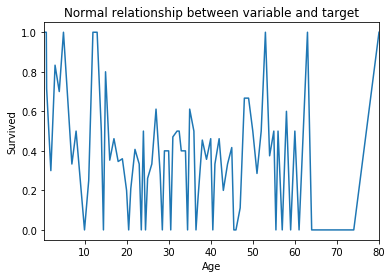

In [7]:
fig = plt.figure()
fig = data.groupby(['Age'])['Survived'].mean().plot()
fig.set_title('Normal relationship between variable and target')
fig.set_ylabel('Survived')

By looking at the plot, we get an intuition that younger people (children) were more likely to survive (see higher survival rates at ages below 10 and 10-15). However, it looks like children of 10 years of age, had a very low survival chance. This does not make a lot of sense and most likely indicates that our 10 year old sample is not big enough and then the survival rate is underestimated. Let's see below.

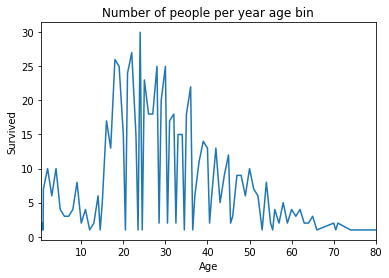

In [8]:
# here I plot the number of passengers within each 1 year age bucket / bin
fig = plt.figure()
fig = data.groupby(['Age'])['Survived'].count().plot()
fig.set_title('Number of people per year age bin')
fig.set_ylabel('Survived')

As we suspected, there were very few children at the age of 10 on the Titanic. If none of them or only half of the 10 year old children survived, we would be led to think that being 10 years old decreased your chances of survival, when in reality, there were only 2 children of the age that were not lucky enough  to survive, therefore leading to underestimation of survival rate.

By grouping Age into bins, we can get a better view of the survival rate depending on the Age of the passenger. Let's see below.

### Discretisation with quantiles

In [9]:
# I will divide Age in 5 bins. I use the qcut (quantile cut) function from pandas and I indicate that I want 4 cutting points, thus 5 bins.
# retbins= True indicates that I want to capture the limits of each interval (so I can then use them to cut the test set)

Age_disccretised, intervals = pd.qcut(data.Age, 4, labels=None, retbins=True, precision=3, duplicates='raise')
pd.concat([Age_disccretised, data.Age], axis=1).head(10)

,Age,Age
0,"(20.125, 28.0]",22.0
1,"(28.0, 38.0]",38.0
2,"(20.125, 28.0]",26.0
3,"(28.0, 38.0]",35.0
4,"(28.0, 38.0]",35.0
5,NaN,NaN
6,"(38.0, 80.0]",54.0
7,"(0.419, 20.125]",2.0
8,"(20.125, 28.0]",27.0
9,"(0.419, 20.125]",14.0


We can see in the above output how by discretising using quantiles, we placed each Age observation within one interval. For example, age 22 was placed in the 20-28 interval, whereas age 38 was placed into the 28-28 interval. We can visualise the interval cut points below.

In [10]:
intervals

array([  0.42 ,  20.125,  28.   ,  38.   ,  80.   ])

And because we generated the bins using the quantile cut method, we should have roughly the same amount of observations per bin. See below.

In [11]:
# calculate number of passengers per bin
temp = pd.concat([Age_disccretised, data.Age], axis=1)
temp.columns = ['Age_discretised', 'Age']
temp.groupby('Age_discretised')['Age'].count()

Age_discretised
(0.419, 20.125]    179
(20.125, 28.0]     183
(28.0, 38.0]       175
(38.0, 80.0]       177
Name: Age, dtype: int64

In [12]:
# we can also add labels instead of having the interval boundaries, to the bins, as follows:

Age_disccretised, intervals = pd.qcut(data.Age, 4, labels=['Q1', 'Q2', 'Q3', 'Q4'], retbins=True, precision=3, duplicates='raise')
Age_disccretised.head()

0    Q2
1    Q3
2    Q2
3    Q3
4    Q3
Name: Age, dtype: category
Categories (4, object): [Q1 < Q2 < Q3 < Q4]

In [13]:
# and now, I will divide into 10 quantiles for the rest of the exercise. I will leave the quantile
# boundary and generate labels as well for comparison

# create 10 labels, one for each quantile
labels = ['Q'+str(i+1) for i in range(0,10)]
print(labels)

# bins with labels
X_train['Age_disc_label'], bins = pd.qcut(x=X_train.Age, q=10, labels=labels, retbins=True, precision=3, duplicates='raise')

# bins with boundaries
X_train['Age_disc'], bins = pd.qcut(x=X_train.Age, q=10, retbins=True, precision=3, duplicates='raise')


X_train.head(10)

['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10']


,Age,Fare,Survived,Age_disc_label,Age_disc
857,51.0,26.5500,1,Q10,"(49.0, 80.0]"
52,49.0,76.7292,1,Q9,"(41.6, 49.0]"
386,1.0,46.9000,0,Q1,"(0.669, 13.2]"
124,54.0,77.2875,0,Q10,"(49.0, 80.0]"
578,14.5,14.4583,0,Q2,"(13.2, 19.0]"
549,8.0,36.7500,1,Q1,"(0.669, 13.2]"
118,24.0,247.5208,0,Q4,"(22.0, 26.0]"
12,20.0,8.0500,0,Q3,"(19.0, 22.0]"
157,30.0,8.0500,0,Q6,"(29.0, 32.0]"
127,24.0,7.1417,1,Q4,"(22.0, 26.0]"


Age 51 was placed into the 49-80 bucket, which is also the last bucket (Q10) in our distribution, as it contains the majority of the elder people. The age of 8 was placed into the 0-13 bucket, which is the first interval (Q1) of the discretised variable. And below the interval limits.

In [14]:
bins

array([  0.67,  13.2 ,  19.  ,  22.  ,  26.  ,  29.  ,  32.  ,  36.  ,
        41.6 ,  49.  ,  80.  ])

To divide the test set, we will use the cut method of pandas, and we will pass the interval edges above. 

As with all feature engineering methods, the limits of the intervals should be set on the training set, and then propagated to the test set. We should not calculate the quantiles in the test set. We should use the limits estimated using the train set data. If the distributions are similar, we should expect to have roughly the same amount of observations in each age bucket in the test set as well.

In [15]:
# we use pandas cut method and pass the quantile edges calculated in the training set
X_test['Age_disc_label'] = pd.cut(x = X_test.Age, bins=bins, labels=labels)
X_test['Age_disc'] = pd.cut(x = X_test.Age, bins=bins)

X_test.head()

,Age,Fare,Survived,Age_disc_label,Age_disc
495,42.0,14.4583,0,Q9,"(41.6, 49.0]"
648,18.0,7.5500,0,Q2,"(13.2, 19.0]"
278,7.0,29.1250,0,Q1,"(0.67, 13.2]"
31,35.0,146.5208,1,Q7,"(32.0, 36.0]"
255,29.0,15.2458,1,Q5,"(26.0, 29.0]"


In [16]:
# let's check that we have equal frequency (equal number of observations per bin)
X_test.groupby('Age_disc')['Age'].count()

Age_disc
(0.67, 13.2]    26
(13.2, 19.0]    38
(19.0, 22.0]    24
(22.0, 26.0]    33
(26.0, 29.0]    21
(29.0, 32.0]    25
(32.0, 36.0]    22
(36.0, 41.6]    22
(41.6, 49.0]    23
(49.0, 80.0]    32
Name: Age, dtype: int64

### Discretisation by quantiles guarantees same number of observations in each partition/bin/interval

In [17]:
t1 = X_train.groupby(['Age_disc'])['Survived'].count() / np.float(len(X_train))
t1

Age_disc
(0.669, 13.2]    0.101124
(13.2, 19.0]     0.115570
(19.0, 22.0]     0.088283
(22.0, 26.0]     0.113965
(26.0, 29.0]     0.099518
(29.0, 32.0]     0.088283
(32.0, 36.0]     0.109149
(36.0, 41.6]     0.083467
(41.6, 49.0]     0.105939
(49.0, 80.0]     0.094703
Name: Survived, dtype: float64

In [18]:
t2 = X_test.groupby(['Age_disc'])['Survived'].count() / np.float(len(X_test))
t2

Age_disc
(0.67, 13.2]    0.097015
(13.2, 19.0]    0.141791
(19.0, 22.0]    0.089552
(22.0, 26.0]    0.123134
(26.0, 29.0]    0.078358
(29.0, 32.0]    0.093284
(32.0, 36.0]    0.082090
(36.0, 41.6]    0.082090
(41.6, 49.0]    0.085821
(49.0, 80.0]    0.119403
Name: Survived, dtype: float64

In [19]:
temp = pd.concat([t1,t2], axis=1)
temp.columns = ['train', 'test']
temp

,train,test
Age_disc,,
"(0.669, 13.2]",0.101124,0.097015
"(13.2, 19.0]",0.115570,0.141791
"(19.0, 22.0]",0.088283,0.089552
"(22.0, 26.0]",0.113965,0.123134
"(26.0, 29.0]",0.099518,0.078358
"(29.0, 32.0]",0.088283,0.093284
"(32.0, 36.0]",0.109149,0.082090
"(36.0, 41.6]",0.083467,0.082090
"(41.6, 49.0]",0.105939,0.085821


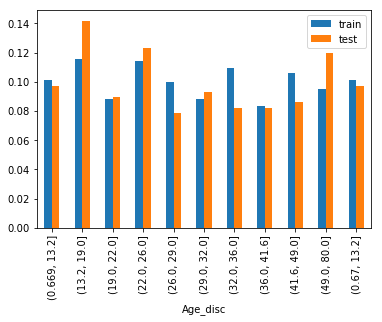

In [20]:
temp.plot.bar()

Indeed, we see roughly the same frequency per interval in both training and testing set.

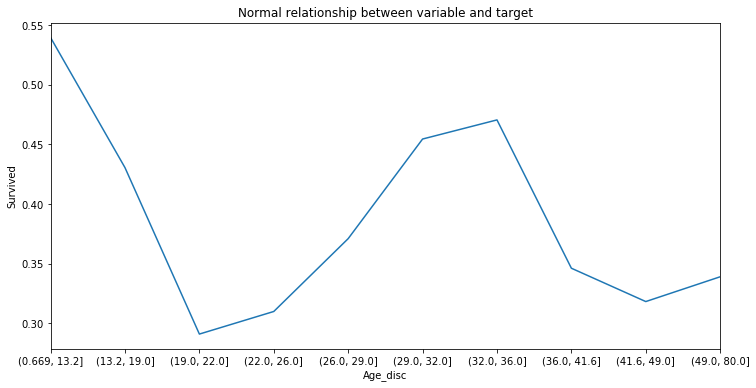

In [21]:
# and now let's observe the relationship between age and survival again, using the discrete Age transformed 
# variable

fig = plt.figure()
fig = X_train.groupby(['Age_disc'])['Survived'].mean().plot(figsize=(12,6))
fig.set_title('Normal relationship between variable and target')
fig.set_ylabel('Survived')

Using discretisation we capture more clearly the survival rate according to the age of the passenger. We can see that children (<18) were the most likely to survive, and people in the early 30s as well, potentially mother with children, whereas people between 20-30 and older than 35 were the less likely to survive the tragedy.

Now that we have a discrete variable, we can go ahead and preprocess it as categorical variable, to squeeze a bit more performance out of the machine learning algorithm. Why not ordering the bins according to survival rate?


### Combine discretisation with label ordering according to target

You can revise the lectures on engineering categorical variables to re-cap on how to preprocess labels.

For this demonstration I will assign ordinal numbers to the different bins, according to the survival rate per bin.

In [22]:
# order the intervals according to survival rate
ordered_labels = X_train.groupby(['Age_disc_label'])['Survived'].mean().sort_values().index

# number the intervals according to survival rate
ordinal_label = {k:i for i, k in enumerate(ordered_labels, 0)} 

# remap the intervals to the encoded variable
X_train['Age_disc_ordered'] = X_train.Age_disc_label.map(ordinal_label)
X_test['Age_disc_ordered'] = X_test.Age_disc_label.map(ordinal_label)

X_train.head()

,Age,Fare,Survived,Age_disc_label,Age_disc,Age_disc_ordered
857,51.0,26.5500,1,Q10,"(49.0, 80.0]",3
52,49.0,76.7292,1,Q9,"(41.6, 49.0]",2
386,1.0,46.9000,0,Q1,"(0.669, 13.2]",9
124,54.0,77.2875,0,Q10,"(49.0, 80.0]",3
578,14.5,14.4583,0,Q2,"(13.2, 19.0]",6


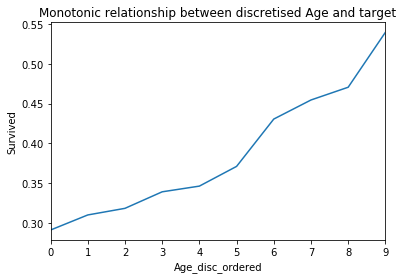

In [23]:
# plot the monotonic relationship
fig = plt.figure()
fig = X_train.groupby(['Age_disc_ordered'])['Survived'].mean().plot()
fig.set_title('Monotonic relationship between discretised Age and target')
fig.set_ylabel('Survived')

Go ahead and compare the performance machine learning algorithms using the original distribution of Age, Age discretised using quantiles and Age in quantiles followed by ordering according to Survival rate. Enjoy!

### Fare

Let's look at the benefit that can be bought forward by equal frequency discretisation on highly skewed variables like Fare.

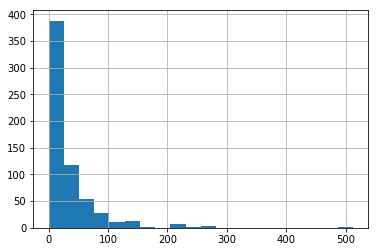

In [24]:
# let's plot the hist, to remind us of the skewness of Fare
X_train.Fare.hist(bins=20)

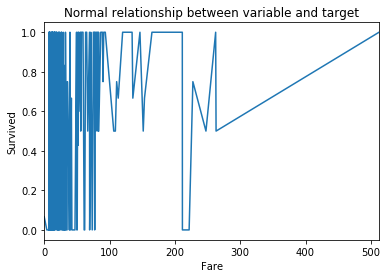

In [25]:
# let's plot survival rate per ticket price
fig = plt.figure()
fig = data.groupby(['Fare'])['Survived'].mean().plot()
fig.set_title('Normal relationship between variable and target')
fig.set_ylabel('Survived')

The relationship between Fare and survival is not very clear from this plot. It looks very noisy for the lowest fares, and the survival rate was highest for highest fares, however, there were very few people that paid > 500 dollars, so most likely that survival rate is inflated.

Let's go ahead and discretise Fare using equal frequency intervals, and plot again the survival rate and the number of observations within bins.

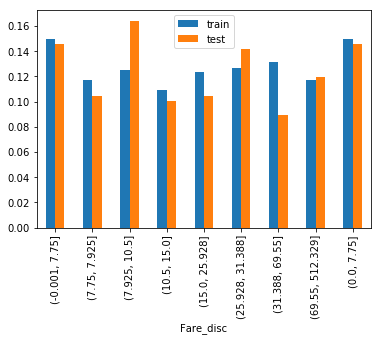

In [26]:
# calculate quantile boundaries on train set and create the discrete variable
X_train['Fare_disc'], bins = pd.qcut(x=X_train.Fare, q=8, retbins=True, precision=3, duplicates='raise')

# cut test set using bin boundaries estimated above
X_test['Fare_disc'] = pd.cut(x = X_test.Fare, bins=bins)

# if the distributions in train and test set are similar, we should expect similar distribution of 
# observations in the different intervals in the train and test set
t1 = X_train.groupby(['Fare_disc'])['Survived'].count() / np.float(len(X_train))
t2 = X_test.groupby(['Fare_disc'])['Survived'].count() / np.float(len(X_test))
temp = pd.concat([t1,t2], axis=1)
temp.columns = ['train', 'test']
temp.plot.bar()

Indeed, we have now spread the observations evenly for all the intervals in both train and test set. Let's go ahead and plot the survival rate per Fare once again.

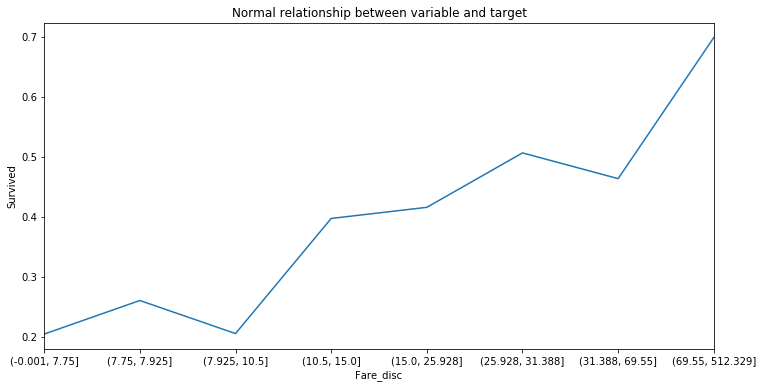

In [27]:
# let's plot survival rate per ticket price bin
fig = plt.figure()
fig = X_train.groupby(['Fare_disc'])['Survived'].mean().plot(figsize=(12,6))
fig.set_title('Normal relationship between variable and target')
fig.set_ylabel('Survived')

Now we get a much clearer view and as we have similar amount of passengers within each bucket, we can be confident that the conclusions are fair. We can see, clearly, that people that paid the highest Fares (>68 dollars) were the most likely to survive, and people who paid the lowest Fares (<10 dollars) were the less likely to survive. Sad but true.

**That is all for this demonstration. I hope you enjoyed the notebook, and see you in the next one.**